In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/TrOCR/fr/train/train.csv")

# Rename columns
train_df.rename(columns={'file-name': 'file_name'}, inplace=True)

valid_df = pd.read_csv(f"/content/drive/MyDrive/TrOCR/fr/valid/valid.csv")

# Rename columns
valid_df.rename(columns={'file-name': 'file_name'}, inplace=True)

print("Valid DataFrame:")
print(valid_df.head())

print("Train DataFrame:")
print(train_df.head())

Mounted at /content/drive
Valid DataFrame:
    file_name                                              text
0  000000.png                                millions de dinars
1  000040.png                                       Vingt mille
2  000077.png                                   cent dix dinars
3  000137.png                                   SIX CENT TRENTE
4  000391.png  cent vingt-trois mille quatre cent cinquante-six
Train DataFrame:
    file_name                     text
0  000225.png                cinquante
1  000258.png                    douze
2  000158.png                       un
3  000109.png  Vingt six milles dinars
4  000023.png       cent Vingts Dinars


Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(os.path.join(self.root_dir, file_name)).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [5]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/drive/MyDrive/TrOCR/fr/train',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/drive/MyDrive/TrOCR/fr/valid',
                           df=valid_df,
                           processor=processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 340
Number of validation examples: 61


Let's verify an example from the training dataset:

In [7]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

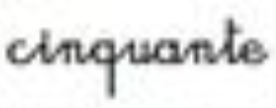

In [8]:
image = Image.open(os.path.join(train_dataset.root_dir, train_df['file_name'][0])).convert("RGB")
image


In [9]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

cinquante


## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [10]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [11]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [12]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

per_device_train_batch_size=6
steps_per_epoch = len(train_dataset) // per_device_train_batch_size

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    fp16=True,
    output_dir="./",
    logging_steps=steps_per_epoch // 10,  # Log 10 times per epoch
    save_steps=50,  # Save once per epoch
    eval_steps=steps_per_epoch,  # Evaluate once per epoch
    num_train_epochs=60  # Train for 100 epochs
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [13]:
!pip install -q evaluate
import evaluate

#from datasets import load_metric

# Old:
# cer_metric = load_metric("cer")

# New:
import evaluate
cer_metric = evaluate.load("cer")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00


The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [14]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [15]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss,Cer
56,1.793600,1.867232,1.070334
112,0.910800,1.403219,0.357939
168,1.164200,1.623963,0.364903
224,0.967800,1.555140,0.467270
280,1.039600,1.167013,0.346797
336,0.700900,1.019083,0.314067
392,0.693700,1.070923,0.275766
448,0.679700,1.033908,0.323816
504,0.560900,1.013473,0.269499
560,0.514300,1.141236,0.329387


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (http

SafetensorError: Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })